In [1]:
!pip install catboost
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [90]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier, BaggingRegressor, StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from catboost import CatBoostRegressor
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder

# Домашняя работа: ансамбли

Эта домашняя работа является идейным продолжением предыдущей. В данной работе вам будет необходимо поэкспериментировать с различными методами ансамблирования и проверить, какие из них работают лучше. Пайплайн предобработки данных можно взять полностью из предыдущей работы.

Требования к домашней работе:
- Во всех графиках (если вы их строите) должны быть подписи через title, legend, etc.
- Во время обучения моделей проверяйте, что у вас не текут данные. Обычно это позитивно влияет на качество модели на тесте, но негативно влияет на оценку 🌚
- Если вы сдаете работу в Google Colaboratory, убедитесь, что ваша тетрадка доступна по ссылке. Если в итоге по каким-то причинам тетрадка не будет открываться у преподавателя, задание не будет засчитано
- Использование мемов допускается. Если задания дались тяжело, можно дополнительно приложить какой-нибудь постироничный мем про ваши страдания во время выполнения данной домашней работы. За мемы с использованием нецензурной лексики баллы будут снижены.

# Загрузка и подготовка данных (1 балл)

В этой секции предлагается прогнать предобработку данных из прошлой тетрадки заново и сохранить получившийся датасет в формате csv.

Если вы **не хотите заморачиваться**, то просто скопируйте код с предобработкой ниже.

В противном случае в старой тетрадке:
1. Отдельно выполните предобработку (`fit_transform`) тренировочной части данных
2. Добавьте колонку `split` к датафрейму с обучающей выборкой, в этой колонке проставьте значение `train` для всех объектов
3. Затем примените **только** предобработку (`transform`) к тестовой части данных
4. Добавьте колонку `split` к тестовой выборке, в этой колонке проставьте значение `test` для всех объектов
5. Объедините два датафрейма в один при помощи функции `pd.concat`
6. Сохраните получившийся датафрейм при помощи функции `to_csv`, не забудьте передать аргумент `index=False`

Получившийся файл сохраните отдельно и используйте в этой домашней работе. Для разбиения датасета на обучающую и тестовую части вместо функции `train_test_split` можете применять колонку `split`.

In [16]:
!gdown 18PVwZWFbpRbEHW-Hc8R0DUTl9CF1aQa0 -O data.csv

Downloading...
From: https://drive.google.com/uc?id=18PVwZWFbpRbEHW-Hc8R0DUTl9CF1aQa0
To: /content/data.csv
100% 30.0M/30.0M [00:00<00:00, 264MB/s]


In [17]:
df = pd.read_csv('data.csv').drop(columns=[
    'product_name',
    'index',
    'uniq_id',
    'customers_who_bought_this_item_also_bought',
    'items_customers_buy_after_viewing_this_item',
    'sellers',
    'description', # text
    'product_information', # text
    'product_description', # text
    'customer_questions_and_answers', # text
    'customer_reviews', # text
])

In [96]:
df = df.drop(index=df[df.isna().sum(axis=1) > 2].index)
df = df.reset_index(drop=True)
X, y = df.drop(columns=['price']), df.price

df_copy = df.copy()

# Переведем доступное количество в численное значение и отделим состояние в отдельный признак
df_copy[["number_available_in_stock", "condition"]] = df_copy["number_available_in_stock"].dropna().str.split(expand=True)
df_copy["number_available_in_stock"] = df_copy["number_available_in_stock"].dropna().astype(float)

# Переведем стоимость в численное значение
df_copy["price"] = df_copy["price"].str.replace('£', '').str.replace(',', '').astype(float)

# Переведем рейтинг в численное значение
df_copy["average_review_rating"] = df_copy["average_review_rating"].dropna().apply(lambda x: float(x.split()[0]))

# Переводим число отзывов в численное значение
df_copy["number_of_reviews"] = df_copy["number_of_reviews"].dropna().str.replace(',', '').astype(float)

# Переводим число ответов в численное значение
df_copy["number_of_answered_questions"] = df_copy["number_of_answered_questions"].dropna().astype(float)

# Заполняем пропуски по среднему и округляем там, где значения должны быть целыми
df_copy["average_review_rating"] = df_copy["average_review_rating"].fillna(np.mean(df_copy["average_review_rating"].dropna()))
df_copy["number_of_reviews"] = df_copy["number_of_reviews"].fillna(np.mean(df_copy["number_of_reviews"].dropna())).round(0)
df_copy["number_of_answered_questions"] = df_copy["number_of_answered_questions"].fillna(np.mean(df_copy["number_of_answered_questions"].dropna())).round(0)
df_copy["number_available_in_stock"] = df_copy["number_available_in_stock"].fillna(np.mean(df_copy["number_available_in_stock"].dropna()))

# Заполним пропуски в текстовых данных
df_copy[["manufacturer", "amazon_category_and_sub_category", "condition"]] = df_copy[["manufacturer", "amazon_category_and_sub_category", "condition"]].fillna("no information")

# Разделим amazon_category_and_sub_category на 5 признаков (тк максимум встречается 5 категорий) и заполним все пропуски
df_copy[["amazon_category", "1_sub_category", "2_sub_category", "3_sub_category", "4_sub_category"]] = df_copy["amazon_category_and_sub_category"].str.split(" > ", expand=True)
df_copy[["1_sub_category", "2_sub_category", "3_sub_category", "4_sub_category"]] = df_copy[["1_sub_category", "2_sub_category", "3_sub_category", "4_sub_category"]].fillna("no_category")
df_copy = df_copy.drop(columns=["amazon_category_and_sub_category", "4_sub_category"])

X, y = df_copy.drop(columns=['price']), df_copy.price
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.65, random_state=42)
X_train_new, X_test_new = X_train, X_test

# Кодируем категориальные признаки

features = ["manufacturer", "condition", "amazon_category", "1_sub_category", "2_sub_category", "3_sub_category"]
encoder = TargetEncoder(cols=features, handle_missing='value', handle_unknown='value')
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test)

/usr/local/lib/python3.8/dist-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/usr/local/lib/python3.8/dist-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


Кодируем TargetEncoder для быстроты

In [19]:
# Нормализуем признаки

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scl = scaler.transform(X_train)
X_test_scl = scaler.transform(X_test)

X_train = pd.DataFrame(X_train_scl, index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scl, index=X_test.index, columns=X_test.columns)

Важно: во всех разделах ниже задачу регрессии важно оценивать не только при помощи `MSE`, но и при помощи `r2_score`. Если вы хотите перебрать какой-либо гиперпараметр, не забывайте оценивать то, насколько сильно переобучается модель и как меняется каждый из параметров в процессе обучения.

# Стекинг (максимум 3 балла)

Решите задачу, используя разные комбинации базовых моделей. В качестве базовой модели обязательно попробуйте линейную регрессию, дерево и SVM для регрессии.

Какой набор моделей дает лучший результат? Попробуйте улучшить его, перебрав несколько гиперпараметров (как у базовой модели, так и у ансамбля).

## Простой стекинг своими руками (2 балла)

In [41]:
class StackingRegressionSolver:
    def __init__(self, base_estimators: list, meta_estimator):
        self._base_estimators = base_estimators
        self._meta_estimator = meta_estimator

    def _fit_base(self, X: pd.DataFrame, y: pd.Series) -> None:
        for estimator in self._base_estimators:
            estimator.fit(X, y)

    def _predict_base(self, X: pd.DataFrame) -> pd.DataFrame:
        meta_features = pd.DataFrame()
        for estimator in self._base_estimators:
            meta_features[type(estimator).__name__] = estimator.predict(X)
        return meta_features

    def fit(self, X: pd.DataFrame, y: pd.Series):
        self._fit_base(X, y)
        meta_features = self._predict_base(X)
        self._fit_base(X, y)
        self._meta_estimator.fit(meta_features, y)

    def predict(self, X: pd.DataFrame) -> pd.Series:
        meta_features = self._predict_base(X)
        return self._meta_estimator.predict(meta_features)

In [64]:
line_regression = LinearRegression()
tree = DecisionTreeRegressor(max_depth=10)
svr = LinearSVR()

estimators = [[[line_regression, svr], [tree]], [[line_regression, tree], [svr]], [[tree, svr], [line_regression]]]

for est in estimators:
    stacking_regressor = StackingRegressionSolver(base_estimators=est[0], meta_estimator=est[1][0])
    stacking_regressor.fit(X_train, y_train)
    y_pred = stacking_regressor.predict(X_test)
    print(f'base_estimators: {est[0]}, final_estimator: {est[1][0]}')
    print(f'mse: {mse(y_test, y_pred)}, r2_score: {r2_score(y_test, y_pred)}\n')

base_estimators: [LinearRegression(), LinearSVR()], final_estimator: DecisionTreeRegressor(max_depth=10)
mse: 1572.7105438694068, r2_score: 0.07780067751525976

base_estimators: [LinearRegression(), DecisionTreeRegressor(max_depth=10)], final_estimator: LinearSVR()
mse: 3421.0784937631684, r2_score: -1.0060374627827793

base_estimators: [DecisionTreeRegressor(max_depth=10), LinearSVR()], final_estimator: LinearRegression()
mse: 3322.3514296852486, r2_score: -0.9481463066774982



/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


**Ответ:** лучший результат был при комбинации базовой модели [LinearRegression(), LinearSVR()] и DecisionTreeRegressor(max_depth=10)    
Ps: увеличением каоличества итераций проблему в ConvergenceWarning решить не получается

In [70]:
# Переберем несколько гиперпараметров

for max_depth in range(10, 31, 2):
  for C in np.arange(0.5, 5.1, 0.5):
    stacking_regressor = StackingRegressionSolver(base_estimators= [LinearRegression(), LinearSVR(C=C)], meta_estimator=DecisionTreeRegressor(max_depth=max_depth))
    stacking_regressor.fit(X_train, y_train)
    y_pred = stacking_regressor.predict(X_test)
    print(f'C for LinearSVR: {C}, max_depth for DecisionTreeRegressor: {max_depth}')
    print(f'mse: {mse(y_test, y_pred)}, r2_score: {r2_score(y_test, y_pred)}\n')

C for LinearSVR: 0.5, max_depth for DecisionTreeRegressor: 10
mse: 1779.7622463000716, r2_score: -0.043609419495399315

C for LinearSVR: 1.0, max_depth for DecisionTreeRegressor: 10
mse: 1671.8139542101715, r2_score: 0.01968884108837221

C for LinearSVR: 1.5, max_depth for DecisionTreeRegressor: 10
mse: 1635.7011582113068, r2_score: 0.04086450887606652

C for LinearSVR: 2.0, max_depth for DecisionTreeRegressor: 10
mse: 1731.850096594856, r2_score: -0.015514896845205683

C for LinearSVR: 2.5, max_depth for DecisionTreeRegressor: 10
mse: 1761.0640450205792, r2_score: -0.03264524772275634

C for LinearSVR: 3.0, max_depth for DecisionTreeRegressor: 10
mse: 1593.8448198096219, r2_score: 0.06540805063980193

C for LinearSVR: 3.5, max_depth for DecisionTreeRegressor: 10
mse: 1708.8741303814802, r2_score: -0.0020423474571431566

C for LinearSVR: 4.0, max_depth for DecisionTreeRegressor: 10
mse: 1667.0129322622597, r2_score: 0.02250404392710026

C for LinearSVR: 4.5, max_depth for DecisionTreeR

Лучший результат при C=1.0, max_depth=10:  
mse: 1671.8139542101715, r2_score: 0.01968884108837221

## Использование встроенной модели стекинга (0.5 балла)

In [71]:
estimators = [("ln_reg", LinearRegression()), ("svr", LinearSVR())]
clf = StackingRegressor(estimators, tree)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f'mse: {mse(y_test, y_pred)}, r2_score: {r2_score(y_test, y_pred)}\n')

mse: 1871.7272294534341, r2_score: -0.09753545533648267



## Блендинг (0.5 балла)

Реализуйте схему блендинга. Для этого разбейте **тестовую** выборку на *валидационную* и *тестовую* части, при необходимости также доработайте код класса `StackingRegressionSolver`. Используйте для обучения базовых моделей обучающую выборку, а для обучения метамодели - валидационную.

Как изменилось качество? Как вы думаете, правдоподобнее ли выглядит такой результат?

In [72]:
class BlendingRegressionSolver:
    def __init__(self, base_estimators: list, meta_estimator):
        self._base_estimators = base_estimators
        self._meta_estimator = meta_estimator

    def _fit_base(self, X: pd.DataFrame, y: pd.Series) -> None:
        for estimator in self._base_estimators:
            estimator.fit(X, y)

    def _predict_base(self, X: pd.DataFrame) -> pd.DataFrame:
        meta_features = pd.DataFrame()
        for estimator in self._base_estimators:
            meta_features[type(estimator).__name__] = estimator.predict(X)
        return meta_features

    def fit(self, X_train, X_valid: pd.DataFrame, y_train, y_valid:pd.Series):
        self._fit_base(X_train, y_train)
        meta_features = self._predict_base(X_valid)
        self._meta_estimator.fit(meta_features, y_valid)

    def predict(self, X: pd.DataFrame) -> pd.Series:
        meta_features = self._predict_base(X)
        return self._meta_estimator.predict(meta_features)

In [73]:
X_valid, X_new_test, y_valid, y_new_test = train_test_split(X_test, y_test, train_size=0.65, random_state=42)

In [74]:
blending_regressor = BlendingRegressionSolver([line_regression, svr], tree)
blending_regressor.fit(X_train, X_valid, y_train, y_valid)
y_pred = blending_regressor.predict(X_new_test)

print(f'mse: {mse(y_new_test, y_pred)}, r2_score: {r2_score(y_new_test, y_pred)}\n')

mse: 1780.437845490899, r2_score: -0.369571082822884



**Ответ:** качество не улучшилось

# Бэггинг (максимум 3 балла)

В этой секции аналогично нужно решить задачу при помощи бэггинга - сначала написанного самостоятельно, а затем взятого из sklearn.

## Бэггинг своими руками (2 балла)

Решите задачу, используя в качестве базовой модели линейную регрессию, дерево и SVM. Какой из алгоритмов в качестве базовой модели дает лучший результат? Почему, как вы думаете?

In [75]:
from typing import Tuple


class BaggingRegressionSolver:
    def __init__(
        self,
        base_estimator_ctor,
        max_samples: float = 1,
        n_estimators: int = 10,
        sample_random_state=42,
        **model_kwargs
    ):
        if max_samples < 0 or max_samples > 1:
            raise ValueError
        self._estimators = [
            base_estimator_ctor(**model_kwargs) for _ in range(n_estimators)
        ]
        self.n_estimators = n_estimators
        self._max_samples = max_samples
        self._random_state = sample_random_state

    def _sample_data(self, X: pd.DataFrame, y: pd.Series) -> Tuple[pd.DataFrame, pd.Series]:
        x_i = X.sample(frac=self._max_samples, random_state=self._random_state)
        y_i = y.loc[x_i.index]
        return x_i, y_i

    def fit(self, X: pd.DataFrame, y: pd.Series):
        for estimator in self._estimators:
            x_i, y_i = self._sample_data(X, y)
            estimator.fit(x_i, y_i)

    def predict(self, X: pd.DataFrame) -> pd.Series:
        pred = pd.DataFrame()
        for i in range(self.n_estimators):
            pred[i] = self._estimators[i].predict(X)
        return pred.mean(axis=1)

In [76]:
estimators = [LinearRegression, DecisionTreeRegressor, LinearSVR]

for estimator in estimators:
    bagging_regressor = BaggingRegressionSolver(estimator, n_estimators=10, max_samples=0.5)
    bagging_regressor.fit(X_train, y_train)
    y_pred = bagging_regressor.predict(X_test)
    print(f'base_estimator_ctor: {estimator}')
    print(f'mse: {mse(y_test, y_pred)}, r2_score: {r2_score(y_test, y_pred)}\n')

base_estimator_ctor: <class 'sklearn.linear_model._base.LinearRegression'>
mse: 1394.7455912546416, r2_score: 0.18215500982842403

base_estimator_ctor: <class 'sklearn.tree._classes.DecisionTreeRegressor'>
mse: 1851.9907673363248, r2_score: -0.0859624725879451

base_estimator_ctor: <class 'sklearn.svm._classes.LinearSVR'>
mse: 1417.8653120696292, r2_score: 0.1685981662282272



**Ответ:** лучше всего справились деревья, попробуем улучшить результат, подобрав гиперпараметры для деревьев

In [77]:
for n_estimators in range(10, 51, 2):
  for max_samples in np.arange(0.01, 1, 0.2):  
    bagging_regressor = BaggingRegressionSolver(DecisionTreeRegressor, n_estimators=n_estimators, max_samples=max_samples)
    bagging_regressor.fit(X_train, y_train)
    y_pred = bagging_regressor.predict(X_test)
    print(f'n_estimators: {n_estimators}, max_samples: {max_samples}')
    print(f'mse: {mse(y_test, y_pred)}, r2_score: {r2_score(y_test, y_pred)}\n')

n_estimators: 10, max_samples: 0.01
mse: 1611.9597149086037, r2_score: 0.05478591546541578

n_estimators: 10, max_samples: 0.21000000000000002
mse: 1935.512132553928, r2_score: -0.1349373756410972

n_estimators: 10, max_samples: 0.41000000000000003
mse: 1856.607436399723, r2_score: -0.08866957536601072

n_estimators: 10, max_samples: 0.6100000000000001
mse: 1877.0282878873927, r2_score: -0.1006438674440413

n_estimators: 10, max_samples: 0.81
mse: 1687.9136555958582, r2_score: 0.010248366636183448

n_estimators: 12, max_samples: 0.01
mse: 1620.3684066310493, r2_score: 0.04985526256196182

n_estimators: 12, max_samples: 0.21000000000000002
mse: 1895.3708198989602, r2_score: -0.11139948338345262

n_estimators: 12, max_samples: 0.41000000000000003
mse: 1889.9991587126508, r2_score: -0.10824967153413168

n_estimators: 12, max_samples: 0.6100000000000001
mse: 1911.9303455846823, r2_score: -0.12110958765379687

n_estimators: 12, max_samples: 0.81
mse: 1702.8170741453102, r2_score: 0.00150936

Лучший результат при n_estimators=12, max_samples=0.81

## Использование встроенной модели бэггинга (1 балл)

Решите задачу, используя:
- `sklearn.ensemble.BaggingRegressor`. В качестве базовой модели попробуйте линейную регрессию, дерево и SVM
- `sklearn.ensemble.RandomForestRegressor`

Какая модель дает лучший результат? Попробуйте улучшить его, перебрав несколько гиперпараметров (как у базовой модели, так и у ансамбля).



In [78]:
estimators = [line_regression, tree, svr]

for estimator in estimators:
    bagg = BaggingRegressor(estimator, n_estimators=12)
    bagg.fit(X_train, y_train)
    y_pred = bagg.predict(X_test)

    print(f'base_estimator_ctor: {estimator}')
    print(f'mse: {mse(y_test, y_pred)}, r2_score: {r2_score(y_test, y_pred)}\n')

base_estimator_ctor: LinearRegression()
mse: 1373.0515609819633, r2_score: 0.19487586306960925

base_estimator_ctor: DecisionTreeRegressor(max_depth=10)
mse: 1823.2434355661903, r2_score: -0.06910573440112255

base_estimator_ctor: LinearSVR()
mse: 1427.085492276405, r2_score: 0.16319167615729802



**Ответ:** лучший результат при деревьях

In [79]:
for max_depth in range(10, 20):
    tree = DecisionTreeRegressor(random_state=42, max_depth=max_depth)
    bagg = BaggingRegressor(tree, n_estimators=10)
    bagg.fit(X_train, y_train)
    y_pred = bagg.predict(X_test)

    print(f'max_depth: {max_depth}')
    print(f'mse: {mse(y_test, y_pred)}, r2_score: {r2_score(y_test, y_pred)}\n')


max_depth: 10
mse: 1534.5551940626592, r2_score: 0.10017404932109719

max_depth: 11
mse: 1971.2337054923937, r2_score: -0.1558836397138823

max_depth: 12
mse: 2491.467312146904, r2_score: -0.4609360102602198

max_depth: 13
mse: 2012.4549501422796, r2_score: -0.18005477790347868

max_depth: 14
mse: 2050.7704210706906, r2_score: -0.2025220408518973

max_depth: 15
mse: 1750.3157894247186, r2_score: -0.026342731301642663

max_depth: 16
mse: 2135.3599676303033, r2_score: -0.2521232995391056

max_depth: 17
mse: 2920.0242897240437, r2_score: -0.7122314288026441

max_depth: 18
mse: 1672.8331549782636, r2_score: 0.0190912064750135

max_depth: 19
mse: 2103.6273007093355, r2_score: -0.23351603321840564



Лучший результат при глубине 18

# Бустинг (максимум 3 балла)

## Бустинг своими руками (2 балла)

Решите задачу при помощи алгоритма бустинга, используя в качестве базовой модели:
- Линейную регрессию
- Дерево
- Случайный лес

Какая модель дает лучший результат? Попробуйте улучшить его, перебрав несколько гиперпараметров (как у базовой модели, так и у ансамбля).

In [80]:
from abc import ABC, abstractmethod
from collections import deque
from typing import Tuple

from sklearn.dummy import DummyRegressor


class Loss(ABC):
    """
    Базовый класс для функции потерь
    """
    @abstractmethod
    def forward(self, y_true: pd.Series, y_pred: pd.Series) -> float:
        """
        Метод, вычисляющий значение функции потерь
        """
        pass

    @abstractmethod
    def backward(self, y_true: pd.Series, y_pred: pd.Series) -> pd.Series:
        """
        Метод, вычисляющий значение градиента функции потерь по предсказаниям модели
        """
        pass


class MSELoss(Loss):
    def forward(self, y_pred: pd.Series, y_true: pd.Series) -> float:  # посчитаем значение ошибки
        return ((np.array(y_pred) - np.array(y_true)) ** 2).mean()

    def backward(self, y_pred: pd.Series, y_true: pd.Series) -> pd.Series:  # посчитаем производную по выходам модели
        return np.array(y_true) - np.array(y_pred)


class GradientBoostingRegressionSolver:
    def __init__(
        self,
        base_estimator_ctor,
        n_estimators: int = 10,
        loss: Loss = MSELoss(),
        learning_rate: float = 0.1,
        early_stopping: int = 5,
        **model_kwargs
    ):
        if early_stopping < 0:
            raise ValueError

        self._ctor = base_estimator_ctor
        self._kwargs = model_kwargs
        self._n_estimators = n_estimators
        self._estimators = []
        self._early_stopping = early_stopping
        self._loss = loss
        self._lr = learning_rate
        self._random_state = 42

    def _sample_data(self, X: pd.DataFrame, y: pd.Series, frac: float) -> Tuple[pd.DataFrame, pd.Series]:
        x_sample = X.sample(frac=frac, random_state=self._random_state)
        y_sample = y.loc[x_sample.index]
        return x_sample, y_sample

    def _split_data(self, X: pd.DataFrame, y: pd.Series, val_size: float) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
        x_val, y_val = self._sample_data(X, y, val_size)
        x_train, y_train = X[~X.index.isin(x_val.index)], y[~y.index.isin(y_val.index)]
        return x_train, x_val, y_train, y_val

    def predict(self, X: pd.DataFrame) -> pd.Series:
        pred = pd.DataFrame()
        for i in range(len(self._estimators)):
            pred[i] = self._estimators[i].predict(X)
        return pred.sum(axis=1)

    def fit(self, X: pd.DataFrame, y: pd.Series, val_size: float = 0.1):
        x_train, x_val, y_train, y_val = self._split_data(X, y, val_size)  # Хотим получить валидационную выборку, не тратя на это время снаружи
        base_estimator = DummyRegressor()  # Создадим и обучим базовую модель
        base_estimator.fit(x_train, y_train)
        self._estimators.append(base_estimator)  # Добавим базовую модель в список моделей

        y_pred_train, y_pred_val = base_estimator.predict(x_train), base_estimator.predict(x_val)  # Посчитаем предсказания как на обучающей, так и на валидационной выборках
        train_loss= self._loss.forward(y_pred_train, y_train)  # Посчитаем значение функции потерь для обучения
        val_loss = self._loss.forward(y_pred_val, y_val) # Посчитаем значение функции потерь для валидации
        residuals = self._loss.backward(y_pred_train, y_train)*self._lr  # Посчитаем остатки, используя градиент функции потерь
        
        #print(f'train loss: {train_loss}, val loss: {val_loss}')

        previous_val_loss, cnt = val_loss, 0
        for i in range(self._n_estimators - 1):
            estimator = self._ctor(**self._kwargs)  # Создадим очередную модель
            # 1. Обучим её и добавим в список моделей
            estimator.fit(x_train, residuals)
            self._estimators.append(estimator)
            # 2. Предскажем ВСЕМ ансамблем данные из обучающей выборки, то же самое сделаем для валидационной
            y_pred_train = self.predict(x_train)
            y_pred_val = self.predict(x_val)
            # 3. Посчитаем значения функции потерь (на обучении и валидации)
            train_loss = self._loss.forward(y_pred_train, y_train)
            val_loss =  self._loss.forward(y_pred_val, y_val)
            # 4. Обновим остатки для обучающей выборки
            residuals = self._loss.backward(y_pred_train, y_train) * self._lr
            #print(f'train loss: {train_loss}, val loss: {val_loss}')
            # Если валидационный лосс несколько (self._early_stopping) шагов подряд не уменьшается, то остановим обучение
            if cnt >= previous_val_loss:
                cnt += 1
            else:
                cnt = 0
            previous_val_loss = val_loss
            if cnt == self._early_stopping:
                print(f'Валидационный лосс не уменьшается {self._early_stopping} шагов подряд, остановим обучение')
                break

Вопросы на дополнительный балл:
- Почему градиент по ответам мы берем со знаком минус?
- Почему в обучении мы домножаем на `learning_rate`, а в предсказаниях этого не делаем?

In [81]:
estimators = [LinearRegression, DecisionTreeRegressor, RandomForestRegressor]

for estimator in estimators:
    boost = GradientBoostingRegressionSolver(estimator)
    boost.fit(X_train, y_train)
    y_pred = boost.predict(X_test)

    print(f'base_estimator_ctor: {estimator}')
    print(f'mse: {mse(y_test, y_pred)}, r2_score: {r2_score(y_test, y_pred)}\n')

base_estimator_ctor: <class 'sklearn.linear_model._base.LinearRegression'>
mse: 1431.8573127314555, r2_score: 0.16039359636580652

base_estimator_ctor: <class 'sklearn.tree._classes.DecisionTreeRegressor'>
mse: 2811.1402687734203, r2_score: -0.6483844795076841

base_estimator_ctor: <class 'sklearn.ensemble._forest.RandomForestRegressor'>
mse: 1584.0906455686081, r2_score: 0.0711276618623029



**Ответ:** лучший результат на лесе

In [82]:
def plot_fitting_curve(parameter: str, values: list, X_train, X_test, y_train, y_test, name='title', xlabel='xlabel', ylabel='ylabel'):
    train_curve = []
    test_curve = []
    for value in values:
        model = GradientBoostingRegressionSolver(RandomForestRegressor, **{parameter: value})
        model.fit(X_train, y_train)
        y_pred_train, y_pred_test = model.predict(X_train), model.predict(X_test)
        train_curve.append(mse(y_train, y_pred_train))
        test_curve.append(mse(y_test, y_pred_test))
    sns.lineplot(x=values, y=train_curve, label='train').set(title=name, xlabel=xlabel, ylabel=ylabel)
    sns.lineplot(x=values, y=test_curve, label='test')

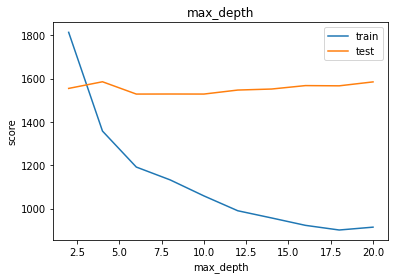

In [83]:
plot_fitting_curve('max_depth', np.arange(2, 21, 2), X_train, X_test, y_train, y_test, name='max_depth', xlabel='max_depth', ylabel='score')

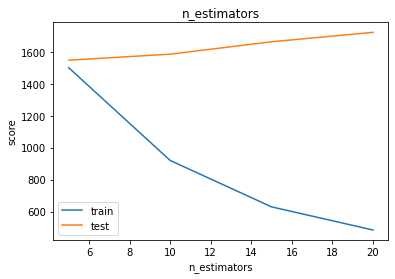

In [84]:
plot_fitting_curve('n_estimators',  np.arange(5, 21, 5), X_train, X_test, y_train, y_test, name='n_estimators', xlabel='n_estimators', ylabel='score')

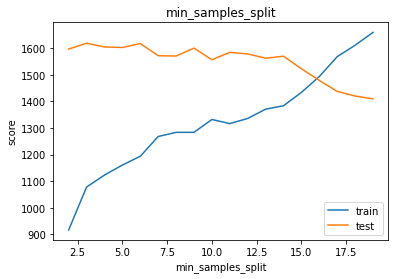

In [85]:
plot_fitting_curve('min_samples_split', np.arange(2, 20), X_train, X_test, y_train, y_test, name='min_samples_split', xlabel='min_samples_split', ylabel='score')

In [86]:
boost = GradientBoostingRegressionSolver(RandomForestRegressor, max_depth=5, min_samples_split=6, n_estimators=10)
boost.fit(X_train, y_train)
y_pred = boost.predict(X_test)

print(f'base_estimator_ctor: {RandomForestRegressor}')
print(f'mse: {mse(y_test, y_pred)}, r2_score: {r2_score(y_test, y_pred)}\n')

base_estimator_ctor: <class 'sklearn.ensemble._forest.RandomForestRegressor'>
mse: 1607.6694384155371, r2_score: 0.05730162955571738



# Catboost (1 балл)

Решите эту же задачу при помощи `catboost`, не перебирая гиперпараметры. Насколько лучше или хуже справился катбуст? В качестве эксперимента также попробуйте закинуть в него данные без предобработки (разумеется, выкинув ненужные колонки). Изменилось ли качество? Каким образом?

In [92]:
catboosting = CatBoostRegressor(metric_period=50, random_state=42)
catboosting.fit(X_train, y_train)
y_pred = catboosting.predict(X_test)

print(f'mse: {mse(y_test, y_pred)}, r2_score: {r2_score(y_test, y_pred)}\n')

Learning rate set to 0.05367
0:	learn: 48.2877724	total: 4.91ms	remaining: 4.91s
50:	learn: 34.8255576	total: 235ms	remaining: 4.37s
100:	learn: 29.3078506	total: 374ms	remaining: 3.33s
150:	learn: 26.8487288	total: 597ms	remaining: 3.36s
200:	learn: 25.5004871	total: 854ms	remaining: 3.39s
250:	learn: 24.6712869	total: 1.21s	remaining: 3.6s
300:	learn: 24.0301188	total: 1.62s	remaining: 3.75s
350:	learn: 23.5266433	total: 1.8s	remaining: 3.33s
400:	learn: 23.0420869	total: 1.9s	remaining: 2.84s
450:	learn: 22.5529684	total: 1.98s	remaining: 2.41s
500:	learn: 22.1748163	total: 2.06s	remaining: 2.06s
550:	learn: 21.8030196	total: 2.16s	remaining: 1.76s
600:	learn: 21.4846148	total: 2.26s	remaining: 1.5s
650:	learn: 21.2102953	total: 2.36s	remaining: 1.26s
700:	learn: 20.9729825	total: 2.44s	remaining: 1.04s
750:	learn: 20.7316554	total: 2.52s	remaining: 837ms
800:	learn: 20.5376977	total: 2.62s	remaining: 652ms
850:	learn: 20.3259437	total: 2.71s	remaining: 474ms
900:	learn: 20.0934787	

In [97]:
X_train_new = X_train_new.drop(columns=["manufacturer", "condition", "amazon_category", "1_sub_category", "2_sub_category", "3_sub_category"])
X_test_new = X_test_new.drop(columns=["manufacturer", "condition", "amazon_category", "1_sub_category", "2_sub_category", "3_sub_category"])

In [98]:
catboosting.fit(X_train_new, y_train)
y_pred = catboosting.predict(X_test_new)

print(f'mse: {mse(y_test, y_pred)}, r2_score: {r2_score(y_test, y_pred)}\n')

Learning rate set to 0.05367
0:	learn: 48.7657250	total: 2.37ms	remaining: 2.37s
50:	learn: 47.2544711	total: 63.9ms	remaining: 1.19s
100:	learn: 46.8658673	total: 124ms	remaining: 1.11s
150:	learn: 46.6884593	total: 186ms	remaining: 1.05s
200:	learn: 46.4545373	total: 267ms	remaining: 1.06s
250:	learn: 46.2984700	total: 338ms	remaining: 1.01s
300:	learn: 46.1759020	total: 400ms	remaining: 928ms
350:	learn: 46.0664447	total: 463ms	remaining: 857ms
400:	learn: 45.9737387	total: 546ms	remaining: 815ms
450:	learn: 45.8979389	total: 608ms	remaining: 740ms
500:	learn: 45.8349759	total: 678ms	remaining: 675ms
550:	learn: 45.7800725	total: 738ms	remaining: 602ms
600:	learn: 45.7279410	total: 808ms	remaining: 536ms
650:	learn: 45.6891223	total: 877ms	remaining: 470ms
700:	learn: 45.6468587	total: 941ms	remaining: 402ms
750:	learn: 45.6072473	total: 1.01s	remaining: 334ms
800:	learn: 45.5776382	total: 1.07s	remaining: 267ms
850:	learn: 45.5451077	total: 1.14s	remaining: 200ms
900:	learn: 45.511